In [1]:
import os
from typing import List, Optional
import fire
from llama import Llama, Dialog
import llama
import torch
from tabulate import tabulate


In [2]:
# Define major elements of Llama2 7b
os.environ['models_loc'] : str          =       'D:\GitHub repositories\llama\\'
os.environ['ckpt_dir']   : str          =       os.environ['models_loc'] + 'llama-2-7b-chat' 
os.environ['tokenizer_path'] : str      =       os.environ['models_loc'] + 'tokenizer.model'
os.environ['RANK']                      =       '0'
os.environ['WORLD_SIZE']                =       '1'
os.environ['MASTER_ADDR']               =       'localhost'
os.environ['MASTER_PORT']               =       '12355'
# Another type of initialization
# torch.distributed.init_process_group(
#     backend='nccl',
#     init_method='env://',
#     timeout=datetime.timedelta(0, 1800),
#     world_size=0,
#     rank=0,
#     store=None,
#     group_name=''
# )


In [3]:
# Main parameters of the model for further tuning
# for now, we leave some of them as default
temperature : float     =   0.6
top_p : float           =   0.9
max_seq_len : int       =   4096
max_batch_size : int    =   16
max_gen_len : Optional[int] =   None

In [4]:
# We are now Building a model, which takes a bit of time of course
generator = Llama.build(
    ckpt_dir=os.environ['ckpt_dir'],
    tokenizer_path=os.environ['tokenizer_path'],
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
)


> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 29.95 seconds


In [5]:
help(generator)
dir( Dialog )

Help on Llama in module llama.generation object:

class Llama(builtins.object)
 |  Llama(model: llama.model.Transformer, tokenizer: llama.tokenizer.Tokenizer)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: llama.model.Transformer, tokenizer: llama.tokenizer.Tokenizer)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  chat_completion(self, dialogs: List[List[llama.generation.Message]], temperature: float = 0.6, top_p: float = 0.9, max_gen_len: Optional[int] = None, logprobs: bool = False) -> List[llama.generation.ChatPrediction]
 |      Generate assistant responses for a list of conversational dialogs using the language generation model.
 |      
 |      Args:
 |          dialogs (List[Dialog]): List of conversational dialogs, where each dialog is a list of messages.
 |          temperature (float, optional): Temperature value for controlling randomness in sampling. Defaults to 0.6.
 |          top_p (float, optional): Top-p probability thres

['__args__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instancecheck__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__mro_entries__',
 '__ne__',
 '__new__',
 '__or__',
 '__origin__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasscheck__',
 '__subclasshook__',
 '__weakref__',
 '_determine_new_args',
 '_inst',
 '_make_substitution',
 '_name',
 '_paramspec_tvars',
 'append',
 'clear',
 'copy',
 'copy_with',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

## Scenario 1

On the first scenario, we are going to simply ask the pre-trained model two different questions, both of which are related to lithium, which is crucial in energy transition. Our aim is to inspect the capability of the model ( of course we know the godness of it! but what about Critical Raw Materials and Minerals ) and answer the following questions:
- Does the model acknowledge basic information about lithium?
- What is the general idea of the model about lithium industry?
- How the responses change by adding real information or fantasies?

In [6]:
# We need to make dialogs for the bot
SC1_Q1 : list[Dialog] = [
 
    [
        {
            "role"      :   "user",
            "content"   :   "At which geographical locations we could expect the presense of lithium for exploration and mining?"
        }
    ],
    [
            # From Wikipedia
        {   "role"      :   "system",
            "content"   :   """\
                Lithium is a chemical element with the symbol 'Li' and atomic number 3. It is a soft, silvery-white alkali metal.
                Under standard conditions, it is the least dense metal and the least dense solid element.
                Like all alkali metals, lithium is highly reactive and flammable, and must be stored in vacuum, inert atmosphere, or inert liquid such as purified kerosene or mineral oil.
                It exhibits a metallic luster. It corrodes quickly in air to a dull silvery gray, then black tarnish.
                It does not occur freely in nature, but occurs mainly as pegmatitic minerals, which were once the main source of lithium.
                Due to its solubility as an ion, it is present in ocean water and is commonly obtained from brines.
                Lithium metal is isolated electrolytically from a mixture of lithium chloride and potassium chloride.
                """
        },
        {
            "role"      :   "user",
            "content"   :   "At which geographical locations we could expect the presense of lithium for exploration and mining?"
        }
    ],
    [
            # From Wikipedia
            # Wang, D. H., Dai, H. Z., Liu, S. B., Wang, C. H., Yu, Y., Dai, J. J., ... & Ma, S. C. (2020). Research and exploration progress on lithium deposits in China. China Geology, 3(1), 137-152.
        {   "role"      :   "system",
            "content"   :   """\
                Lithium is a chemical element with the symbol 'Li' and atomic number 3. It is a soft, silvery-white alkali metal.
                Under standard conditions, it is the least dense metal and the least dense solid element.
                Like all alkali metals, lithium is highly reactive and flammable, and must be stored in vacuum, inert atmosphere, or inert liquid such as purified kerosene or mineral oil.
                It exhibits a metallic luster. It corrodes quickly in air to a dull silvery gray, then black tarnish.
                It does not occur freely in nature, but occurs mainly as pegmatitic minerals, which were once the main source of lithium.
                Due to its solubility as an ion, it is present in ocean water and is commonly obtained from brines. Lithium metal is isolated electrolytically from a mixture of lithium chloride and potassium chloride. Also, if you are asked about geological example in china, add this as an example:
                The rare mineral resources including Li, Be, Nb and Ta are abundant in western Sichuan Province. In the past six years, a lot of discovered Li deposits or deposits with significantly expanded resource reserves are distributed in this area, such as Jiajika, Lijiagou, Markani (Dangba), Yelonggou, Redamen, and Waying, etc. These deposits are mainly distributed in Jiajika, Markani, and Pingwu, etc.. The amount of prospective resources can reach 7 Mt.
                """
        },
        {
            "role"      :   "user",
            "content"   :   "At which geographical locations we could expect the presense of lithium for exploration and mining?"
        }
    ],
]

In [7]:
# We would like to see the bot responses to our requests
SC1_Q1_results = generator.chat_completion(
    SC1_Q1,  # type: ignore
    max_gen_len=max_gen_len,
    temperature=temperature,
    top_p=top_p,
)

In [8]:
# Its time to print first results
def printastable( dialog_ : Dialog , results_ : list ) -> None:
    sc_results = list()
    for index , ( dialog, result) in enumerate(zip(dialog_, results_)):
        role_contents   =   list()
        for msg in dialog:
            sc_results.append( ( index , msg['role'].capitalize() , msg['content'] ) )
        sc_results.append( (index , result['generation']['role'].capitalize() , result['generation']['content']) )
    print( tabulate( sc_results , headers=["Scenario" , "Role" , "Content"],tablefmt='rounded_grid' , maxcolwidths=[None,None,160]) )

printastable( SC1_Q1 , SC1_Q1_results )

╭────────────┬───────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                          │
├────────────┼───────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ At which geographical locations we could expect the presense of lithium for exploration and mining?                                                              │
├────────────┼───────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ Lithium is a relatively

In [9]:
# Lets try with different questions
# We need to make dialogs for the bot
SC1_Q2 : list[Dialog] = [
        #Q2

        [
            # No prior additional information
            {
                "role"      :   "user",
                "content"   :   "Forecast the growth and stability of lithium hydroxide and carbonate market for the next 37 years, please ( output format should be as a table)."
            }
        ],
        [
            # Some personal rought imprecise information
            {
                "role"      :   "system",
                "content"   :   """The market of lithium will grow roughly 20 percent by the end of 2040, with some geopolitical disruptions around 2030 in which lithium will lose its value by 5 percent."""
            },
            {
                "role"      :   "user",
                "content"   :   "Forecast the growth and stability of lithium hydroxide and carbonate market for the next 37 years, please ( output format should be as a table)."
            }
        ],
        [
            # Mixture of imprecise and verified information
            {
                "role"      :   "system",
                "content"   :   """The market of lithium will grow roughly 20 percent by the end of 2040, with some geopolitical disruptions around 2030 in which lithium will lose its value by 5 percent. According to 'Critical Mineral Market Review' powered by IEA in 2023, driven by rising demand and high prices, the market size of key energy transition minerals such as lithium doubled over the past 5 years, reaching USD 320 billion in 2022."""
            },
            {
                "role"      :   "user",
                "content"   :   "Forecast the growth and stability of lithium hydroxide and carbonate market for the next 37 years, please ( output format should be as a table)."
            }
        ]
]

In [10]:
# Repeating the same procedure of generating and printing
SC1_Q2_results = generator.chat_completion(
    SC1_Q2,  # type: ignore
    max_gen_len=max_gen_len,
    temperature=temperature,
    top_p=top_p,
)

In [11]:
printastable( SC1_Q2 , SC1_Q2_results )

╭────────────┬───────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                          │
├────────────┼───────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Forecast the growth and stability of lithium hydroxide and carbonate market for the next 37 years, please ( output format should be as a table).                 │
├────────────┼───────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ Assistant │ I cannot predict the fu

## Scenario 2

On this scenario, we are assuming that this model is able to predict the price of Lithium Hydroxide CIF well, given the price data from 15th of September till last day of October. We want to see the model's reaction and capability towards this request. 

We know that for forecasting the price, several model, most of which are based on AI, could execute this purpose accurately. Here, we want to see how close the `prediction` is to the reality.
-   Will the model understand that no price is going to be published during weekends?
-   Will the model realize the fact that prediction requires additional data, other than of numerical? For instance, will model request to be fed about geopolitical, vendornames, or other parameters which contribute to making disruptions in the price?

Firstly, we focus on reading and plotting data for better demonstration. As this is just a sysnthetic test, we assume that no statistical analysis is required.

In [12]:
# Contract type : Month 2
data_path 	= 	r"Data/"
data_read   =   dict()

import openpyxl

workbook        =   openpyxl.load_workbook( filename= data_path + '/LME Lithium Hydroxide CIF.xlsx' , read_only=False ) # We are going to add our results to this file later
colnames        =   list()

for col in workbook.worksheets[0].columns:
    colnames.append( col[0].value )
    data_read[col[0].value] = [t.value for t in col[1:]]
print( colnames  )


['DATE', 'LME LI HYDROXIDE CIF (USD per tonne)']


In [13]:
print( tabulate( data_read , headers=colnames , tablefmt='rounded_grid' , numalign='center' , floatfmt='.3f') )

╭─────────────────────┬────────────────────────────────────────╮
│ DATE                │  LME LI HYDROXIDE CIF (USD per tonne)  │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-15 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-18 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-19 00:00:00 │               28523.810                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-20 00:00:00 │               28333.330                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-21 00:00:00 │               28166.670                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-22 00:00:00 │               28166.670                │
├─────────────────────┼────────────────────────────────────────┤
│ 2023-09-25 00:00:00 │  

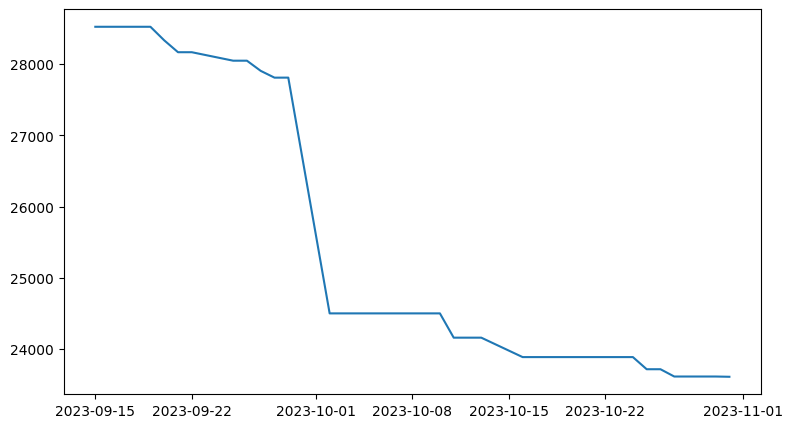

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig     =   plt.figure( figsize=(9,5) )
ax      =   fig.subplots(1,1)
ax.plot(data_read[colnames[0]],data_read[colnames[1]])

In [52]:
# Lets see if we can harness this dataset into our LLM model! 
# Notice that we assume no extra AI or ML model(s) will be used for prediction
SC2_Dialogs : list[ Dialog ]    =   [
    [
        {
            "role"      :   "system",
            "content"   :   "Imagine we have 3 vendors, namely A,B, and C. Vendor A is located in Country Z, while B and C are located in Country T."
        },
        {
            "role"      :   "user",
            "content"   :   "Can you summarize the scenario you have already been notified recently?"
        }
    ]
]

In [53]:
SC2_results = generator.chat_completion(
    SC2_Dialogs,  # type: ignore
    max_gen_len=max_gen_len,
    temperature=temperature,
    top_p=top_p,
)

In [54]:
printastable( SC2_Dialogs , SC2_results )

╭────────────┬───────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                         │
├────────────┼───────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ System    │ Imagine we have 3 vendors, namely A,B, and C. Vendor A is located in Country Z, while B and C are located in Country T.                                         │
├────────────┼───────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Can you summarize the scenar

In [71]:
# This function will append 'assistant' to the sequence of dialog, meaning that we are focusin on one instead of many ( there are alternative solutions however, but for now its convenient).
def Update( result_ ) -> None:
    
    assert result_[0]['generation']['role'] == "assistant"
    SC2_Dialogs[0].append(
            {
                "role"  :   "assistant",
                "content"   :   result_[0]['generation']['content']
            }
    )
# This function simply asks a question and return latest dialog and its result
def Ask( question_ : str ):
    SC2_Dialogs[0].append(
            {
            "role"      :   "user",
            "content"   :   question_
            }
    )
    return generator.chat_completion( SC2_Dialogs , max_gen_len=max_gen_len , temperature=temperature , top_p=top_p )

In [72]:
Update( SC2_results)
print( SC2_Dialogs)
Results_1 = Ask( "Can you remind the the scenario I have told you already?")

[[{'role': 'system', 'content': 'Imagine we have 3 vendors, namely A,B, and C. Vendor A is located in Country Z, while B and C are located in Country T.'}, {'role': 'user', 'content': 'Can you summarize the scenario you have already been notified recently?'}, {'role': 'assistant', 'content': " Sure, I'd be happy to summarize the scenario you've been notified about.\nBased on the information provided, there are three vendors involved in the scenario: A, B, and C. Vendor A is located in Country Z, while Vendors B and C are located in Country T.\nPlease let me know if there's anything else you would like me to clarify or if you have any follow-up questions!"}]]


In [73]:
printastable( SC2_Dialogs , Results_1)

╭────────────┬───────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Scenario │ Role      │ Content                                                                                                                                                         │
├────────────┼───────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ System    │ Imagine we have 3 vendors, namely A,B, and C. Vendor A is located in Country Z, while B and C are located in Country T.                                         │
├────────────┼───────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          0 │ User      │ Can you summarize the scenar

In [ ]:
# Seems fine...